# Exploration 3. 카메라 스티커앱 만들기 첫걸음

## 목차
1. 사용할 스티커 구하기
2. 얼굴 검출 & 랜드마크 검출
3. 스티커 적용하기
4. 문제점 확인 및 개선
5. 회고

### Step 1. 사용할 스티커 구하기

  - 스티커앱 만들기에 사용할 인물 사진을 구해서 디렉토리에 넣어준다.
  - 여기서는 해리포터의 헤르미온느 사진을 사용해서 작업을 진행한다.

In [1]:
# 사용할 모듈 불러오기

import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import dlib

print('ok')

ok


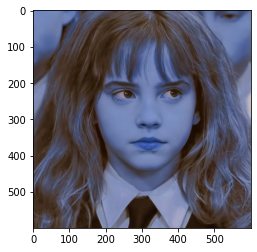

In [2]:
# 준비한 이미지 불러오기

my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/hermi.png'
img_bgr = cv2.imread(my_image_path)    # OpenCV로 이미지를 불러옵니다
img_bgr = cv2.resize(img_bgr, (600, 600))
img_show = img_bgr.copy()      # 출력용 이미지를 따로 보관합니다
plt.imshow(img_bgr)
plt.show()

  - 여기서 이미지의 색이 푸른빛을 띄고 있는 것은 opencv의 특징때문이다.
  - opencv는 예외적으로 BGR(파랑, 녹색, 빨강)을 사용해서 보통의 이미지보다 더 푸른빛을 띄고 있다.
  - 그렇기 때문에 색깔 보정처리를 해주어야 한다.

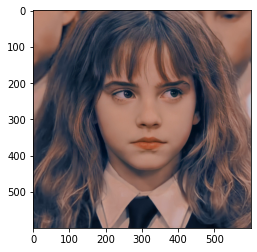

In [3]:
# 색 보정처리

img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

### Step 2. 얼굴 검출

  - dlib의 face detector는 HOG와 SVM을 사용해서 얼굴을 찾는다.
  - 여기서는 HOG를 사용해서 얼굴을 검출한다.
  - HOG는 Histogram of Oriented Gradients로서 이미지에서 색상의 변화량에 따라서 특징을 잡아내는 방식이다.

In [4]:
# detector 선언하기

detector_hog = dlib.get_frontal_face_detector()
print('ok')

ok


In [5]:
# HOG를 통해서 얼굴의 bounding box 추출하기

img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB) # dlib은 rgb이미지를 입력으로 받기 때문에 bgr 이미지를 변환시켜줘야 한다.
dlib_rects = detector_hog(img_rgb, 1)
print('ok')

ok


rectangles[[(171, 171) (438, 439)]]


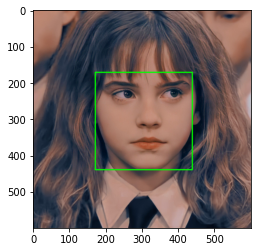

In [6]:
# 검출한 얼굴 출력하기

print(dlib_rects)   

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

### Step 2-1. 랜드마크 검출

  - 스티커를 섬세하게 적용하기 위해서는 이목구비의 위치를 정확하게 아는 것이 중요하다.
  - 이목구비의 위치를 추론하는 것을 face landmark localization 기술이라고 한다.
  - face landmark는 detection의 결과물인 bounding box로 잘라낸 얼굴 이미지를 사용한다.

In [7]:
# 저장한 Landmark 모델 불러오기

model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)
print('ok')

ok


In [8]:
list_landmarks = []

# 얼굴 영역 박스 마다 face landmark를 찾아냅니다
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    # face landmark 좌표를 저장해둡니다
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

68


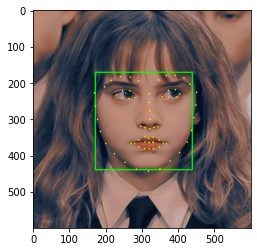

In [9]:
# 찾은 랜드마크를 사진에 출력하기

for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 2, (0, 255, 255), -1)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

### Step 3. 스티커 적용하기

  - 우리가 적용할 스티커는 고양이 수염 모양으로 인물의 코 위쪽에 위치하게 해줘야 한다.
  - 먼저 코 위치의 좌표를 구하고 스티커의 좌표를 지정해 주어야 한다.

In [10]:
# 코 위치 좌표 확인하기

for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) # 코의 index는 30 입니다
    x = landmark[30][0]
    y = landmark[30][1] - dlib_rect.height()//2
    w = h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(322, 301)
(x,y) : (322,167)
(w,h) : (268,268)


(268, 268, 3)


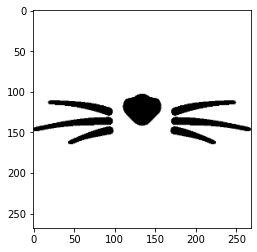

In [11]:
# 준비한 스티커 이미지 불러오기

sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat-whiskers.png'
img_sticker = cv2.imread(sticker_path) # 스티커 이미지를 불러옵니다
img_sticker = cv2.resize(img_sticker, (w,h))
print (img_sticker.shape)
plt.imshow(img_sticker)

  - 불러온 스티커는 윗 단계에서 계산한 크기로 resize 된다.

In [12]:
# x, y 좌표 수정

refined_x = x - w//2 # left
refined_y = y   # top
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (188,167)


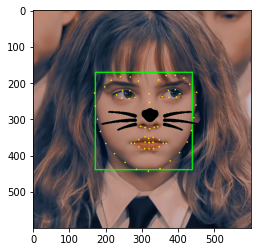

In [13]:
# 스티커 붙여서 이미지 출력하기

sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)
# 배경 이미지에 스티커 이미지 적용 : 스티커 이미지에서 255인 부분은 sticker_area로 사용하고, 255가 아닌 부분은 img_sticker를 다시 적용
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

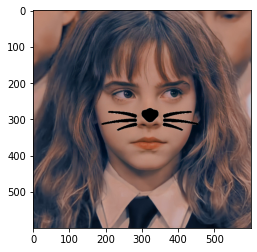

In [14]:
# bounding box와 landmark 제거

sticker_area = img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

### Step 4. 문제점 확인 및 개선

  - 얼굴 각도와 촬영 거리 등에 따른 변수가 생길 경우 어떤 문제들이 발생하고 어떻게 해결해야 하는지 생각해볼 필요가 있다.

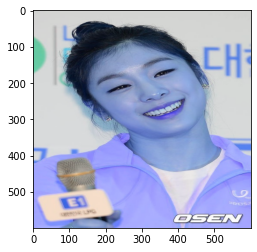

In [15]:
# 갸우뚱 사진 준비하기

# 준비한 이미지 불러오기

my_image_path_1 = os.getenv('HOME')+'/aiffel/camera_sticker/images/kim.png'
img_bgr_1 = cv2.imread(my_image_path_1)    # OpenCV로 이미지를 불러옵니다
img_bgr_1 = cv2.resize(img_bgr_1, (600, 600))
img_show_1 = img_bgr_1.copy()      # 출력용 이미지를 따로 보관합니다
plt.imshow(img_bgr_1)
plt.show()

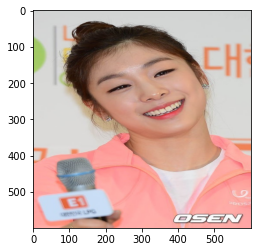

In [16]:
# 색 보정처리

img_rgb_1 = cv2.cvtColor(img_bgr_1, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb_1)
plt.show()

In [17]:
# HOG를 통해서 얼굴의 bounding box 추출하기

img_rgb_1 = cv2.cvtColor(img_bgr_1, cv2.COLOR_BGR2RGB) # dlib은 rgb이미지를 입력으로 받기 때문에 bgr 이미지를 변환시켜줘야 한다.
dlib_rects = detector_hog(img_rgb_1, 1)
print('ok')

ok


rectangles[[(216, 118) (439, 341)]]


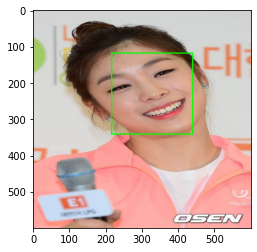

In [18]:
# 검출한 얼굴 출력하기

print(dlib_rects)   

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show_1, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb_1 =  cv2.cvtColor(img_show_1, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb_1)
plt.show()

In [19]:
list_landmarks = []

# 얼굴 영역 박스 마다 face landmark를 찾아냅니다
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb_1, dlib_rect)
    # face landmark 좌표를 저장해둡니다
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

68


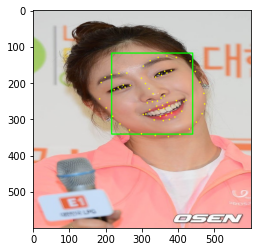

In [20]:
# 찾은 랜드마크를 사진에 출력하기

for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show_1, point, 2, (0, 255, 255), -1)

img_show_rgb_1 = cv2.cvtColor(img_show_1, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb_1)
plt.show()

In [21]:
# 코 위치 좌표 확인하기

for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) # 코의 index는 30 입니다
    x = landmark[30][0]
    y = landmark[30][1] - dlib_rect.height()//2
    w = h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(330, 230)
(x,y) : (330,118)
(w,h) : (224,224)


(224, 224, 3)


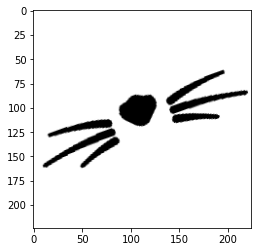

In [22]:
# 준비한 스티커 이미지 불러오기 및 각도조절

sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat-whiskers.png'
img_sticker = cv2.imread(sticker_path) # 스티커 이미지를 불러옵니다
img_sticker = cv2.resize(img_sticker, (w,h))

# 스티커 각도 조절해주기 / cv2.getRotationMatrix2D 사용하기

def rotate_image(image, angle):
  image_center = tuple(np.array(image.shape[1::-1]) / 2)
  rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
  result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR,borderValue=(255,255,255))
  return result

img_rotate = rotate_image(img_sticker,20) # 인물 이미지를 보고 대략적인 각도 20도 설정
print(img_rotate.shape)
plt.imshow(img_rotate)
plt.show()


In [23]:
# x, y 좌표 수정

refined_x = x - w//2 # left
refined_y = y   # top
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (218,118)


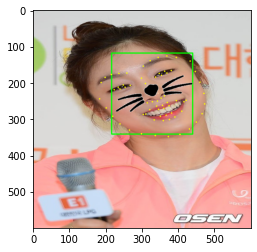

In [24]:
# 스티커 붙여서 이미지 출력하기

sticker_area = img_show_1[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show_1[refined_y:refined_y+img_rotate.shape[0], refined_x:refined_x+img_rotate.shape[1]] = \
    np.where(img_rotate==255,sticker_area,img_rotate).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_show_1, cv2.COLOR_BGR2RGB))
plt.show()

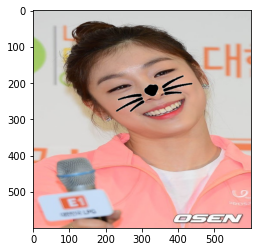

In [25]:
# bounding box와 landmark 지우고 출력하기

sticker_area = img_bgr_1[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr_1[refined_y:refined_y +img_rotate.shape[0], refined_x:refined_x+img_rotate.shape[1]] = \
    np.where(img_rotate==255,sticker_area,img_rotate).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr_1, cv2.COLOR_BGR2RGB))
plt.show()

###  Step 5. 회고

  - 먼저 이번 노드를 진행하면서 좋았던 점은 결과물을 바로바로 볼 수 있었다는 점이다.
  - 정면 사진을 가지고 작업을 진행했을때는 생각보다 쉽게 결과물을 얻을 수 있었다.
  - 하지만 가장 어려웠던 점은 얼굴 각도에 따른 스티커를 붙이는 과정이었다.
  - 첫번째 어려움은 얼굴 각도에 맞춰서 스티커도 회전을 시켜줘야 한다는 것이었다.
  - 스티커 회전에 있어서는 cv2.getRotationMatrix2D 사용했는데 구글에서도 설명이 대부분 영어여서 이해하는데 꽤 어려웠다.
  - 특히 스티커 회전에는 각도를 계산해서 각도를 넣어주어야 하는데 그 각도를 정확하게 구하는 공식은 사실 이해하지 못했다.
  - 그래서 이번에는 인물 사진을 보고 대략적인 각도를 지정해서 넣어주었는데 다행히 스티커랑 사진이랑 잘 매치되었다.
  - 두번째 어려움은 스티커를 회전하는데 있어서 스티커째로 회전이 되는 경우가 있었다.
  - 그러다보니 얼굴 가운데가 네모로 회전되어서 출력되는 경우가 있었다.
  - 같이 공부하는 학우님의 공유로 인해서 한 블로그를 참조하게 되었는데 그 블로그에서 알려준 코드대로 진행하니까 고양이 수염만 회전하였다.
  - 아직 이미지가 통째로 회전한 경우와 고양이 수염만 회전한 경우와 코드의 차이를 정확하게 이해하지는 못했다.
  - 얼굴 각도뿐만 아니라 이미지 밝기, 촬영거리 등 다양한 케이스들이 있지만 시간관계상 시도해보지 못했다.
  - 수학적인 부분들도 나오고 여러 케이스들을 작업하기 위해서는 구글링을 통해서도 정보를 검색해야 하는 것이 생각보다 난이도가 있었다고 생각한다.

### 참조 블로그
https://velog.io/@dldndyd01/OpenCV-%EC%9D%B4%EB%AF%B8%EC%A7%80-%ED%9A%8C%EC%A0%84%EC%A4%91%EC%95%99-%EA%B8%B0%EC%A4%80-%ED%9A%8C%EC%A0%84-cv2.getRotationMatrix2D-%EC%96%BC%EA%B5%B4-%ED%9A%8C%EC%A0%84-%EA%B0%81%EB%8F%84-%EA%B5%AC%ED%95%98%EA%B8%B0